In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import ones, zeros, eye, as_tensor, tensor, float32
from torch.distributions import MultivariateNormal, Exponential

from sbi.inference import NPE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform, MultipleIndependent

from paper.colors import colors

/Users/michaeldeistler/anaconda3/envs/sbitutorial/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams['svg.fonttype'] = 'none'

In [18]:
def simulate(angle, strength, wind):
    xs = [0.0]
    ys = [0.0]

    angle = angle / 180 * pi

    dx = np.cos(angle) * strength
    dy = np.sqrt(strength**2 - dx**2)
    
    for i in range(10_000):
        x, y, dx, dy = step(xs[-1], ys[-1], dx, dy, dt, angle, strength, wind)
        xs.append(x)
        ys.append(y)
        if i > 1 and ys[-1] < 0:
            break
    return xs, ys

def step(x, y, dx, dy, dt, angle, strength, wind):
    gravity = 0.05
    friction_x = friction * dx
    friction_y = friction * dy

    ddy = -gravity - friction_y
    dy += ddy * dt

    ddx = wind - friction_x
    dx += ddx * dt

    return x + dx * dt, y + dy * dt, dx, dy

def throw_distance(xs, ys):
    frac = 1 - (ys[-1] / (ys[-1] - ys[-2]))
    return frac * (xs[-1] - xs[-2]) + xs[-2] + np.random.rand() * 0.1

In [19]:
angle = 45
strength = 0.7
friction = 0.01
dt = 0.5

In [20]:
all_xs = []
all_ys = []
dists = []

for wind in [0.0, 0.01, 0.03]:
    xs, ys = simulate(angle, strength, wind)
    all_xs.append(xs)
    all_ys.append(ys)
    dist = throw_distance(xs, ys)
    dists.append(dist)

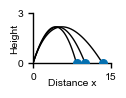

In [21]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1., 0.65))
    for xs, ys in zip(all_xs, all_ys):
        _ = ax.plot(xs, ys, c="k")
    _ = ax.set_xlim([0, 15])
    _ = ax.set_xticks([0, 15])
    _ = ax.set_ylim([0, 3])
    _ = ax.set_yticks([0, 3])
    _ = ax.set_xlabel("Distance x", labelpad=-2)
    _ = ax.set_ylabel("Height", labelpad=-1)
    for dist in dists:
        _ = ax.scatter([dist], [0.0], s=30.0, c=colors["x"], zorder=1000)
    plt.savefig("svg/panel_a.svg", bbox_inches="tight", transparent=True)
    plt.savefig("png/panel_a.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

### Inference

In [9]:
prior_angle = MultivariateNormal(35 * torch.ones((1,)), 15**2 * torch.eye(1))
# prior_strength = Exponential(2.0 * torch.ones((1,)))
# prior_wind = MultivariateNormal(torch.zeros((1,)), 0.001 * torch.eye(1))
prior = prior_angle
latent = Exponential(200.0 * torch.ones((1,)))
#MultipleIndependent([
#    prior_angle,
    # prior_strength,
    # prior_wind,
#])
friction = 0.1
dt = 0.5

In [10]:
num_sims = 10_000

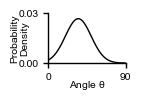

In [11]:
x_axis = torch.linspace(0, 90, 100).unsqueeze(1)
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.0, 0.65))
    _ = ax.plot(x_axis, prior.log_prob(x_axis).exp().numpy(), c="k" ) 
    _ = ax.set_xlim([0, 90])
    _ = ax.set_xticks([0, 90])
    _ = ax.set_ylim([0, 0.025])
    _ = ax.set_yticks([0, 0.03])
    _ = ax.set_xlabel("Angle " + r"$\theta$", labelpad=-2)
    _ = ax.set_ylabel("Probability\nDensity", labelpad=-8)
    plt.savefig("svg/panel_b.svg", bbox_inches="tight", transparent=True)
    plt.savefig("png/panel_b.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

# Train

In [ ]:
theta = prior.sample((num_sims,))
z = latent.sample((num_sims,))
x = []
for t, zz in zip(theta, z):
    trace = simulate(t.item(), 2.0, zz.item())
    dist = throw_distance(*trace)
    x.append(dist)

x = torch.as_tensor(x, dtype=float32).unsqueeze(1)

In [14]:
_ = torch.manual_seed(0)
inference = NPE(prior=prior, density_estimator="nsf")
_ = inference.append_simulations(theta, x).train(max_num_epochs=200)

 Neural network successfully converged after 84 epochs.

In [15]:
posterior = inference.build_posterior()

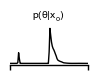

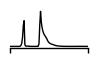

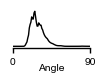

In [16]:
x_os = [13, 15, 16]
x_axis = torch.linspace(0, 90, 100)
for i, x_o_val in enumerate(x_os):
    x_o = as_tensor([[x_o_val]])
#     samples = posterior.sample((100_000,), x=x_o)
    probs = torch.exp(posterior.log_prob(x_axis.unsqueeze(1), x=x_o))
    
    with mpl.rc_context(fname="../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 1, figsize=(1, 0.5))
#         _ = ax.hist(samples.numpy(), range=[0, 90], bins=100, histtype="step", color="k")
        _ = ax.plot(x_axis, probs.numpy(), color="k")
        _ = ax.set_xlim([0, 90])
        _ = ax.set_xticks([0, 90])
        _ = ax.spines["left"].set_visible(False)
        _ = ax.set_yticks([])
        if i == len(x_os) - 1:
            _ = ax.set_xlabel("Angle", labelpad=-2)
        else:
            _ = ax.set_xticklabels([])

        if i == 0:
            ax.set_title(r"$p(\theta | x_o)$")
        plt.savefig(f"svg/panel_c_{i}.svg", bbox_inches="tight", transparent=True)
        plt.savefig(f"png/panel_c_{i}.png", dpi=300, bbox_inches="tight", transparent=True)
        plt.show()

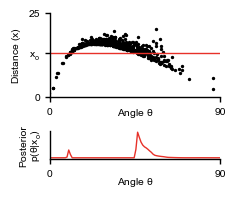

In [17]:
x_o_val = 13.0
x_axis = torch.linspace(0, 90, 100).unsqueeze(1)
probs = posterior.log_prob(x_axis, x=torch.as_tensor([[x_o_val]])).exp().numpy()

with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(2, 1, figsize=(2.2, 1.9), gridspec_kw={'height_ratios': [3, 1]})
    _ = ax[0].scatter(theta[:500, 0].numpy(), x[:500, 0].numpy(), s=2.0, c="k")
    _ = ax[0].axhline(x_o_val, c=colors["theta"])

    _ = ax[0].set_xticks([0, 90])
    _ = ax[0].set_xlim([0, 90])
    # _ = ax[0].set_xticklabels([])

    _ = ax[0].set_yticks([0, x_o_val, 25])
    _ = ax[0].set_yticklabels([0, r"$x_o$", 25])
    _ = ax[0].set_ylim([0, 25])
    _ = ax[0].set_xlabel("Angle " + r"$\theta$", labelpad=-7)

    # _ = ax.axhline(14.0)
    _ = ax[1].plot(x_axis, 20 * probs + x_o_val, c=colors["theta"])
    _ = ax[1].set_xticks([0, 90])
    _ = ax[1].set_xlim([0, 90])
    _ = ax[1].set_yticks([])
    # _ = ax.axvline(70.0, c="r")
    
    _ = ax[1].set_xlabel("Angle " + r"$\theta$", labelpad=-2)
    _ = ax[0].set_ylabel("Distance " + r"$(x)$")
    _ = ax[1].set_ylabel("Posterior\n" + r"$p(\theta | x_o)$")
    plt.subplots_adjust(hspace=0.6)
    plt.savefig("svg/panel_d.svg", bbox_inches="tight", transparent=True, dpi=72)
    plt.savefig("png/panel_d.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

In [33]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_bold = {'size': '10pt', 'font': 'Arial', 'weight': '800'}
kwargs_text = {'size': '7pt', 'font': 'Arial'}

f = Figure("18.0cm", "4.7cm",
    Panel(
        Text("a", 0, 0, **kwargs_bold),
        Text("Simulator", 52, 0, **kwargs_text),
    ).move(0, 10),
    Panel(SVG("svg/panel_a.svg").scale(svg_scale)).move(12, 3),

    Panel(
        Text("b", 0, 0.0, **kwargs_bold),
        Text("Prior", 60, 0.0, **kwargs_text),
    ).move(0, 105),
    Panel(SVG("svg/panel_b.svg").scale(svg_scale)).move(-4, 97),

    Panel(
        Text("c", 0, 0, **kwargs_bold),
        Text("Simulated dataset", 80, 0, **kwargs_text),
    ).move(150, 10),
    Panel(SVG("svg/panel_d.svg").scale(svg_scale)).move(150, 10),

#     Panel(
#         Text("d", -50, -55.0, **kwargs_bold),
#           Text("Simulation-based inference", 20, -55.0, **kwargs_text),
#     ).move(435, 75),
    Panel(SVG("svg/panel_d_comp.svg").scale(3.78)).move(413, 0),
)

!mkdir -p fig
f.save("fig/fig2.svg")
svg("fig/fig2.svg")

In [78]:
import time
import IPython.display as IPd
from svgutils.compose import *

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_bold = {'size': '10pt', 'font': 'Arial', 'weight': '800'}
kwargs_text = {'size': '7pt', 'font': 'Arial'}

f = Figure("4.5cm", "4.4cm",
    Panel(SVG("svg/panel_a_misspec.svg").scale(svg_scale)).move(-6, -6),
)

!mkdir -p fig
f.save("fig/fig2_misspec.svg")
svg("fig/fig2_misspec.svg")